# Introduction

This notebook is a 'quick-start' for the [CGIAR Crop Yield Prediction Challenge](https://zindi.africa/competitions/cgiar-crop-yield-prediction-challenge). We'll take a look at the data, fit a quick model and make a submission, with hints at each stage for extra options to investigate.

Let's dive in!

# Setup

You can get the zip files from Zindi or add to your Google drive using the following links:

Test data: https://drive.google.com/file/d/1yTEgzn8JJn0mZmJ7NDUbwAB1WSzwRScB/view?usp=sharing

Training data: 
https://drive.google.com/file/d/1-0UNiBpvfdRq8rgUC3Kb22YPWP_YnoKj/view?usp=sharing

You'll also need the smaller files from Zindi (Train.csv, SampleSubmission.csv and bandnames.txt) which you can just upload using the files tab.

In [38]:
cd /Users/krishnapatel/MyDesk/Internship2021

/Users/krishnapatel/MyDesk/Internship2021


In [39]:
# Copying in the zip files from Google Drive (alternately just upload them)
!cp 'image_arrays_train.zip' .
!cp 'image_arrays_test.zip' .

cp: ./image_arrays_train.zip and image_arrays_train.zip are identical (not copied).
cp: ./image_arrays_test.zip and image_arrays_test.zip are identical (not copied).


In [40]:
# Extract
#!unzip -q image_arrays_train.zip
#!unzip -q image_arrays_test.zip

In [41]:
# Check the CSV files are present
!ls *.csv # Upload through the files menu

Corr_Skew.csv                correlation1.csv
SampleSubmission.csv         fields_w_additional_info.csv
Sub.csv                      isnull.csv
Train.csv                    sample.csv
X2.csv                       sample1.csv
X3.csv                       skewness.csv
correlation.csv              test_field_ids_with_year.csv


In [42]:
# Check for bandnames.txt
!ls *.txt

bandnames.txt


# Loading the data

The data isn't a simple table - instead we must read the inputs from individual .npy files. Here we'll load the dataframes, open a file or two and take a look at the format.

In [43]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [44]:
# Train.csv has the Field_IDs needed to find the npy files
train = pd.read_csv('Train.csv')
print(train.shape)
train.head()

(2977, 4)


,Field_ID,Year,Quality,Yield
0,MH2O0YH,2019,3,3.686
1,O9TURWL,2019,2,5.657
2,35AFSDD,2019,3,3.082
3,PM05EG9,2019,2,2.707
4,V7PZBCG,2019,2,2.679


Loading image_arrays_train/6HTJQ1G.npy as an array
Array shape: (360, 42, 41)


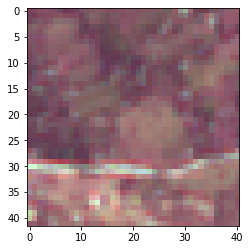

In [45]:
# Look at a sample:
fid = train['Field_ID'].sample().values[0]
fn = f'image_arrays_train/{fid}.npy' # File name based on Field_ID
print(f'Loading {fn} as an array')
arr = np.load(fn) # Loading the data with numpy
print('Array shape:', arr.shape) # 360 bands, images 40 or 41px a side
rgb_jan = np.stack([arr[4], arr[3], arr[2]], axis=-1) # Combine three bands for viewing
rgb_jan = rgb_jan / np.max(rgb_jan) # Scale band values to (0, 1) for easy image display
plt.imshow(rgb_jan) # View with matplotlib

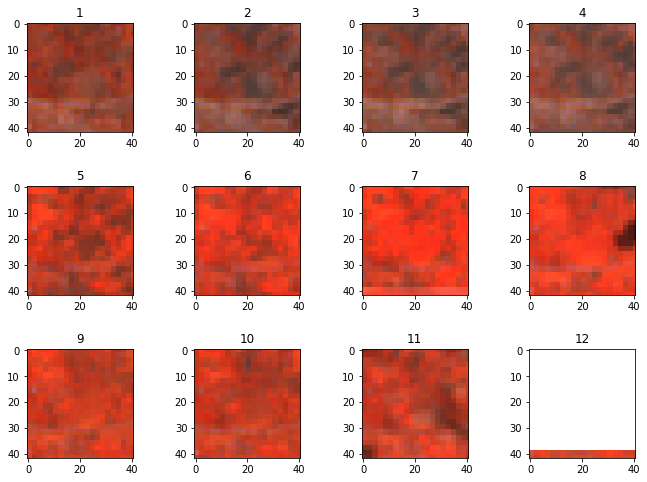

In [46]:
# View false colour images from each month in the year:
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(12):
  rgb = np.stack([arr[i*30 + 8], arr[i*30 + 4], arr[i*30 + 3]], axis=-1) # False colour (band 8, 4 and 3)
  rgb = rgb / 4000 # Scaling consistently 
  axs[i].imshow(rgb.clip(0, 1))
  axs[i].set_title(str(i+1))

What's with the white fluffy stuff? These are clouds - the bane of all remote sensing analysts...

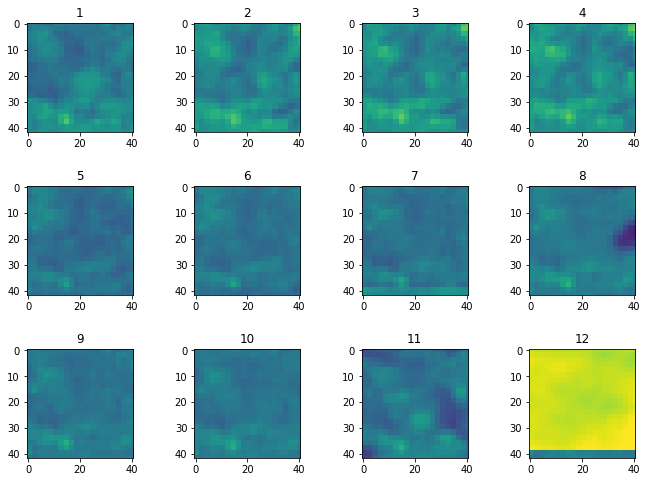

In [47]:
# Show the SWIR band (B12) where clouds have a high reflectance
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(12):
  cloud = arr[i*30 + 11]
  axs[i].imshow(cloud, vmin=0, vmax=4000)
  axs[i].set_title(str(i+1))

# Sampling from the images

There are some hard-coded band indexes in the examples above that won't have made sense - how did we know which bands were which?
There are 30 bands for each month. You can see the full list of bands with:

In [48]:
band_names = [l.strip() for l in open('bandnames.txt', 'r').readlines()]
print(band_names)
#print(len(band_names))

['0_S2_B1', '0_S2_B2', '0_S2_B3', '0_S2_B4', '0_S2_B5', '0_S2_B6', '0_S2_B7', '0_S2_B8', '0_S2_B8A', '0_S2_B9', '0_S2_B10', '0_S2_B11', '0_S2_B12', '0_S2_QA10', '0_S2_QA20', '0_S2_QA60', '0_CLIM_aet', '0_CLIM_def', '0_CLIM_pdsi', '0_CLIM_pet', '0_CLIM_pr', '0_CLIM_ro', '0_CLIM_soil', '0_CLIM_srad', '0_CLIM_swe', '0_CLIM_tmmn', '0_CLIM_tmmx', '0_CLIM_vap', '0_CLIM_vpd', '0_CLIM_vs', '1_S2_B1', '1_S2_B2', '1_S2_B3', '1_S2_B4', '1_S2_B5', '1_S2_B6', '1_S2_B7', '1_S2_B8', '1_S2_B8A', '1_S2_B9', '1_S2_B10', '1_S2_B11', '1_S2_B12', '1_S2_QA10', '1_S2_QA20', '1_S2_QA60', '1_CLIM_aet', '1_CLIM_def', '1_CLIM_pdsi', '1_CLIM_pet', '1_CLIM_pr', '1_CLIM_ro', '1_CLIM_soil', '1_CLIM_srad', '1_CLIM_swe', '1_CLIM_tmmn', '1_CLIM_tmmx', '1_CLIM_vap', '1_CLIM_vpd', '1_CLIM_vs', '2_S2_B1', '2_S2_B2', '2_S2_B3', '2_S2_B4', '2_S2_B5', '2_S2_B6', '2_S2_B7', '2_S2_B8', '2_S2_B8A', '2_S2_B9', '2_S2_B10', '2_S2_B11', '2_S2_B12', '2_S2_QA10', '2_S2_QA20', '2_S2_QA60', '2_CLIM_aet', '2_CLIM_def', '2_CLIM_pdsi', '2

# Fetching Column names for extracking the area of the field from the data

In [49]:
#print(new_band_names)
n = len(band_names)
new_band_names = []
for i in range(n):
    x = band_names[i].split('_',1)[1:]
    y ='_'.join(x)
    new_band_names.append(y)

new_band_names1 = new_band_names[:360]
#print(new_band_names[:360])

0_S2_B1 is band one from the Sentinel 2 image for January (month 0). They're ordered, so we know that the first image band in the array is 0_S2_B1...

You'll likely want to examine specific bands. Here's an example where we create a function to sample the center point (20, 20) for specified bands from each month:

In [50]:
def process_im(fid, folder='image_arrays_train'):
  fn = f'{folder}/{fid}.npy'
  arr = np.load(fn)
  #bands_of_interest = ['S2_B5', 'S2_B4', 'S2_B3', 'S2_B2', 'CLIM_pr', 'CLIM_soil']
  bands_of_interest = new_band_names1
  values = {}
  for month in range(12):
    bns = [str(month) + '_' + b for b in bands_of_interest] # Bands of interest for this month 
    idxs = np.where(np.isin(band_names, bns)) # Index of these bands
    vs = arr[idxs, 20, 20] # Sample the im at the center point
    for bn, v in zip(bns, vs[0]):
      values[bn] = v
  return values

# Example
# process_im('35AFSDD')

With this, we can sample the inputs for each field in train and use that to build a dataframe of input features:

In [51]:
# Make a new DF with the sampled values from each field 
train_sampled = pd.DataFrame([process_im(fid) for fid in train['Field_ID'].values])

# Add in the field ID and yield
train_sampled['Field_ID'] = train['Field_ID'].values
train_sampled['Yield'] = train['Yield'].values
train_sampled.head()

,0_S2_B1,0_S2_B2,0_S2_B3,0_S2_B4,0_S2_B5,0_S2_B6,0_S2_B7,0_S2_B8,0_S2_B8A,0_S2_B9,...,11_CLIM_soil,11_CLIM_srad,11_CLIM_swe,11_CLIM_tmmn,11_CLIM_tmmx,11_CLIM_vap,11_CLIM_vpd,11_CLIM_vs,Field_ID,Yield
0,1024,934,932,1173,1392,1798,2044,2038,2327,1072,...,215,1880,0,100,267,1680,69,210,MH2O0YH,3.686
1,1023,880,821,924,1116,1630,1870,1951,2040,929,...,215,1883,0,99,273,1682,75,190,O9TURWL,5.657
2,1095,1016,1070,1357,1632,1972,2256,2137,2588,957,...,289,1875,0,100,274,1690,76,200,35AFSDD,3.082
3,976,777,784,639,1064,2014,2561,2588,2921,1300,...,189,1898,0,98,263,1688,64,210,PM05EG9,2.707
4,1300,1081,1122,1162,1487,2336,2698,2603,2984,710,...,1214,1930,0,143,291,1972,87,270,V7PZBCG,2.679


In [52]:
train_sampled.to_csv('sample.csv', index = True)

Deleting the unwanted rows for checking the skewness

In [53]:
train_sampled1 = train_sampled.dropna(axis=1)

uniquevalue = []

print(uniquevalue)
type(uniquevalue)

for i in train_sampled1.columns:
    if train_sampled1[i].nunique() == 1:
        del train_sampled1[i]

#del train_sampled1['Field_ID']
train_sampled1.drop(columns = ['0_S2_QA60','1_S2_QA60','2_S2_QA60','3_S2_QA60','3_CLIM_def','3_CLIM_pdsi','4_S2_QA60','5_S2_QA60','6_S2_QA60','7_S2_QA60','8_S2_QA60','9_S2_QA60','10_S2_QA60','11_S2_QA60','4_CLIM_pdsi', '5_CLIM_pdsi', '6_CLIM_pdsi', '7_CLIM_pdsi','8_CLIM_pdsi', '9_CLIM_pdsi', '10_CLIM_pdsi', '11_CLIM_pdsi'], inplace=True)
#print(train_sampled1)
train_sampled1.to_csv('sample1.csv', index = True)
train_sampled1.shape

[]


(2977, 304)

Finding correlation of the data with the target class

In [54]:
train_sampled1.corr()

,0_S2_B1,0_S2_B2,0_S2_B3,0_S2_B4,0_S2_B5,0_S2_B6,0_S2_B7,0_S2_B8,0_S2_B8A,0_S2_B9,...,11_CLIM_pr,11_CLIM_ro,11_CLIM_soil,11_CLIM_srad,11_CLIM_tmmn,11_CLIM_tmmx,11_CLIM_vap,11_CLIM_vpd,11_CLIM_vs,Yield
0_S2_B1,1.000000,0.824599,0.750039,0.527370,0.564373,0.305525,0.219391,0.198817,0.214266,0.053576,...,0.008900,0.022549,0.054306,-0.012560,0.288920,0.188506,0.275418,-0.006023,0.050159,-0.072044
0_S2_B2,0.824599,1.000000,0.951044,0.772900,0.734511,0.283430,0.174712,0.206583,0.181551,0.230760,...,-0.053843,-0.037014,-0.026166,0.022057,0.159328,0.097495,0.125891,0.013553,0.004897,-0.010681
0_S2_B3,0.750039,0.951044,1.000000,0.824434,0.826350,0.395042,0.269059,0.323797,0.273497,0.329163,...,-0.122056,-0.083230,-0.102406,0.088487,0.155075,0.120304,0.054867,0.077182,0.054251,-0.008445
0_S2_B4,0.527370,0.772900,0.824434,1.000000,0.914353,0.009116,-0.141439,-0.066805,-0.133589,0.552781,...,-0.193948,-0.176911,-0.222694,0.135461,0.013901,-0.047623,-0.097894,0.061496,-0.045797,0.107324
0_S2_B5,0.564373,0.734511,0.826350,0.914353,1.000000,0.242701,0.076164,0.143712,0.085384,0.592995,...,-0.251109,-0.202302,-0.270362,0.188521,0.054092,0.016839,-0.124782,0.124463,0.028704,0.068875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11_CLIM_tmmx,0.188506,0.097495,0.120304,-0.047623,0.016839,0.292439,0.292306,0.218749,0.292246,-0.211037,...,-0.413083,-0.290943,-0.421680,0.610643,0.813482,1.000000,0.120992,0.738715,0.712768,-0.325390
11_CLIM_vap,0.275418,0.125891,0.054867,-0.097894,-0.124782,0.097300,0.113892,0.049054,0.085861,-0.360490,...,0.714368,0.523795,0.676039,-0.570642,0.386225,0.120992,1.000000,-0.524035,-0.031109,-0.174264
11_CLIM_vpd,-0.006023,0.013553,0.077182,0.061496,0.124463,0.152756,0.134668,0.122080,0.158020,0.069999,...,-0.829686,-0.641536,-0.846177,0.942200,0.534652,0.738715,-0.524035,1.000000,0.621695,-0.173534
11_CLIM_vs,0.050159,0.004897,0.054251,-0.045797,0.028704,0.311206,0.298721,0.244226,0.279645,0.031143,...,-0.496699,-0.253754,-0.444688,0.564299,0.674688,0.712768,-0.031109,0.621695,1.000000,-0.329681


In [55]:
corrMatrix = train_sampled1.corr()
corrMatrix.to_csv('correlation1.csv', index = True) #saving the correlation values for checking correlation

# Checking the Skewness of Data

In [56]:
train_sampled1.skew(axis = 1, skipna = True)

0       2.311136
1       1.037213
2       2.437013
3       2.461309
4       0.768610
          ...   
2972    0.801159
2973    0.733429
2974    3.124513
2975    0.811658
2976    0.635117
Length: 2977, dtype: float64

Checking skewness Columnwise

In [57]:
skewness = train_sampled1.skew(axis = 0, skipna = True)
print(skewness)
#skewness.to_csv('skewness.csv', index = True)

0_S2_B1         7.043604
0_S2_B2         5.709805
0_S2_B3         3.593708
0_S2_B4         0.863172
0_S2_B5         0.990880
                  ...   
11_CLIM_tmmx   -1.090246
11_CLIM_vap     0.304247
11_CLIM_vpd    -1.380822
11_CLIM_vs     -0.787135
Yield           1.004717
Length: 303, dtype: float64


In [58]:
 corr_skew = pd.read_csv('Corr_Skew.csv')

In [59]:
labels = []
for n in range(len(corr_skew)):
    if (corr_skew['Skew'][n] > 0.49) and (corr_skew['Correlation'][n] > 0.099) :
        labels.append(corr_skew['Bands'][n])
    if (corr_skew['Skew'][n] > 0.49) and (corr_skew['Correlation'][n] < -0.099) :
        labels.append(corr_skew['Bands'][n])
print(labels)

['0_S2_B4', '0_CLIM_pr', '0_CLIM_ro', '0_CLIM_soil', '1_CLIM_srad', '1_CLIM_vpd', '2_S2_B1', '2_S2_B2', '2_S2_B3', '2_S2_B4', '2_S2_B5', '2_S2_B6', '2_S2_B7', '2_S2_B8', '2_S2_B8A', '2_S2_B11', '3_S2_B1', '3_S2_B2', '3_S2_B3', '3_S2_B4', '3_S2_B5', '3_S2_B6', '3_S2_B7', '3_S2_B8', '3_S2_B8A', '3_CLIM_ro', '4_CLIM_pr', '5_CLIM_pr', '5_CLIM_ro', '6_S2_B7', '6_S2_B8', '6_S2_B8A', '6_S2_B9', '6_CLIM_pr', '6_CLIM_ro', '7_S2_B9', '7_CLIM_pr', '7_CLIM_ro', '7_CLIM_soil', '8_S2_B11', '8_S2_B12', '8_CLIM_def', '8_CLIM_soil', '9_S2_B1', '9_S2_B2', '9_S2_B3', '9_S2_B4', '10_S2_B10', '10_CLIM_def', '10_CLIM_pr', '10_CLIM_ro', '11_S2_B9']


In [60]:
print(len(labels))

52


In [61]:
from scipy.stats import skew
import seaborn as sns
from matplotlib import pyplot as plt
x, y  = train_sampled[train_sampled1.columns[:-2]], train_sampled1['Yield']

Changing the skewness using sqaureroot transformation

In [62]:
import copy
X1 = copy.deepcopy(x)  
for i in labels:
    X1[i] = np.sqrt(X1[i])  
skewness = X1.skew()
print(skewness)

0_S2_B1         7.043604
0_S2_B2         5.709805
0_S2_B3         3.593708
0_S2_B4         0.276117
0_S2_B5         0.990880
                  ...   
11_CLIM_tmmn   -0.249349
11_CLIM_tmmx   -1.090246
11_CLIM_vap     0.304247
11_CLIM_vpd    -1.380822
11_CLIM_vs     -0.787135
Length: 302, dtype: float64


From the above boxplot graph we can observe that after applying squareroot transformation we can see that there is outliers.

In [63]:
import copy
X2 = copy.deepcopy(x)  
for i in labels:
    X2[i] = (X2[i])**(1./3.)
print("-----------Change in skewness-----------")
for i in labels:
    print(i)
    print(skew(X2[i]))

-----------Change in skewness-----------
0_S2_B4
0.11460422531169996
0_CLIM_pr
0.32798583836231493
0_CLIM_ro
-1.030859365204628
0_CLIM_soil
0.2279911039600228
1_CLIM_srad
0.7248917150661687
1_CLIM_vpd
1.6432578935793498
2_S2_B1
3.0722363291375525
2_S2_B2
3.0798766078136963
2_S2_B3
2.9621529679268934
2_S2_B4
2.526958179746743
2_S2_B5
2.724140815465622
2_S2_B6
2.127083236454168
2_S2_B7
1.8038276807577052
2_S2_B8
1.6154114765844534
2_S2_B8A
1.5585630402552657
2_S2_B11
0.12691895663913066
3_S2_B1
2.0845447272690745
3_S2_B2
2.0893674120892856
3_S2_B3
2.110305656187448
3_S2_B4
1.8607551759236844
3_S2_B5
2.1071650195547904
3_S2_B6
1.2796885244998246
3_S2_B7
0.8898564581405256
3_S2_B8
0.783666623392113
3_S2_B8A
0.7160884818687334
3_CLIM_ro
0.6796746385068779
4_CLIM_pr
2.0906831487908453
5_CLIM_pr
2.1751182317518998
5_CLIM_ro
3.5085797106068526
6_S2_B7
1.030344918939702
6_S2_B8
0.8402810306012439
6_S2_B8A
0.5982477263377567
6_S2_B9
2.864248021365181
6_CLIM_pr
0.2842208361008189
6_CLIM_ro
0.0161

In [69]:
X4 = x.copy()
for i in labels:
    X4[i] = X4[i]+1
for i in labels:
    X4[i] = np.log10(X3[i])

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [64]:
import copy
X3 = copy.deepcopy(x)  
for i in labels:
    X3[i] = (X3[i])**(1./4.)
print("-----------Change in skewness-----------")
for i in labels:
    print(i)
    print(skew(X3[i]))

-----------Change in skewness-----------
0_S2_B4
0.03744964429004849
0_CLIM_pr
0.2547988722458475
0_CLIM_ro
-1.5087623091227191
0_CLIM_soil
0.16887181990968678
1_CLIM_srad
0.7133010201184499
1_CLIM_vpd
1.6161536152119818
2_S2_B1
2.9827892847068234
2_S2_B2
2.9735661617181752
2_S2_B3
2.835916786124843
2_S2_B4
2.3452437197976077
2_S2_B5
2.559329959857167
2_S2_B6
1.931291760572715
2_S2_B7
1.607786858462908
2_S2_B8
1.4094296808649807
2_S2_B8A
1.3593401533435767
2_S2_B11
-0.08254749689629486
3_S2_B1
1.9921616138978135
3_S2_B2
1.9763368073557996
3_S2_B3
1.9791213665465224
3_S2_B4
1.6841163171084366
3_S2_B5
1.9470123984778203
3_S2_B6
1.0906040811592268
3_S2_B7
0.7082155773352139
3_S2_B8
0.6044755083193546
3_S2_B8A
0.5314188897455667
3_CLIM_ro
0.6534960070479445
4_CLIM_pr
1.9446628500080319
5_CLIM_pr
1.9458854684538087
5_CLIM_ro
3.2652869840848826
6_S2_B7
0.7832090554604352
6_S2_B8
0.5937634433485237
6_S2_B8A
0.34467384763365844
6_S2_B9
2.540345373817404
6_CLIM_pr
0.1577513807621366
6_CLIM_ro
-

# Fitting a model

Now that we have a way to get features from the inputs, we can fit a model and see how it does:

In [71]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.15)

# fit by setting best parameters and Evaluate model
xgb_model = XGBRegressor()

xgb_model.fit(X_train, y_train)

print('Score:', mean_squared_error(y_test, xgb_model.predict(X_test), squared=False))

[03:09:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Score: 1.374964677973129


In [75]:
score = xgb_model.score(X_train, y_train)
print(score)

0.4948557618129611


# Saving Preds

Once we're happy with how we generate our inputs, we must process the test fields in the same way and save predictions. Here it is, condensed. Note the Field_IDs from the sample submission are used, and the same `process_im` function prepares the inputs, this time looking for .npy files in the 'image_arrays_test' folder. 

In [73]:
# Load the sample submission file
ss = pd.read_csv('SampleSubmission.csv')

# Prep the data, using the same method we did for train
test_sampled = pd.DataFrame([process_im(fid, folder='image_arrays_test') for fid in ss['Field_ID'].values])

#Extracting features required
test_sampled1 = test_sampled.dropna(axis=1)

uniquevalue1 = []

print(uniquevalue1)
type(uniquevalue1)

for i in test_sampled1.columns:
    if test_sampled1[i].nunique() == 1:
        del test_sampled1[i]

#del train_sampled1['Field_ID']
test_sampled1.drop(columns = ['0_S2_QA60','1_S2_QA60','2_S2_QA60','3_S2_QA60','3_CLIM_def','3_CLIM_pdsi','4_S2_QA60','5_S2_QA60','6_S2_QA60','7_S2_QA60','8_S2_QA60','9_S2_QA60','10_S2_QA60','11_S2_QA60','4_CLIM_pdsi', '5_CLIM_pdsi', '6_CLIM_pdsi', '7_CLIM_pdsi','8_CLIM_pdsi', '9_CLIM_pdsi', '10_CLIM_pdsi', '11_CLIM_pdsi'], inplace=True)

test_sampled1.shape


# Get model predictions
preds = xgb_model.predict(test_sampled1)

# Store them in the submission dataframe and save
ss['Yield'] = preds
ss.to_csv('Sub.csv', index=False)
ss.head()

[]


,Field_ID,Yield
0,E9UZCEA,2.776425
1,1WGGS1Q,3.264372
2,EG2KXE2,3.528218
3,HC3GQXF,3.071500
4,7AK6GFK,3.040347


In [74]:
ss

,Field_ID,Yield
0,E9UZCEA,2.776425
1,1WGGS1Q,3.264372
2,EG2KXE2,3.528218
3,HC3GQXF,3.071500
4,7AK6GFK,3.040347
...,...,...
1050,3H89LWV,3.810681
1051,I6EYSGB,3.527327
1052,XOEIR44,2.865948
1053,YB307JG,3.019299


You can submit the Sub.csv file generated here on Zindi. This example scores ~2 (not as good as our score on our local test set, because the fields are more geographically separated). Now let's chat about ways to make this better:

# Improvements


1.   For the example above I chose the 'bands of interest' fairly randomly. A bit of research into which Sentinel 2 bands are used in this kind of task and what the different climate variables are should help make more informed choices there.
2.   We looked at all 12 months. Maize is normally planted just before the March-May rainy season (I think?) and harvested a few months later. Choose which months you'll prioritise to cut down on less useful data
3.   We looked at only the center pixel. Can you use a wider area to get better features? What about finding which pixels are most likely fields and sampling those?
4.   We did no model tuning, so obviously lots of fun to be had there
5.   Low-quality locations are often not fields - leave these out of your training set for better results. There are no low-quality (Quality=1) fields in the test set.
6.   Common measures such as NDVI, EVI etc can be computed by combining different bands. Look up how these vegetative indices are calculated for sentinel 2 and see if you can add those as features.
6.   ... As always, be creative - I'm sure there are lots more improvements to be made

